# All Extra-exercises

In [1]:
import tensorflow as tf

2024-07-01 10:26:07.849052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 10:26:07.849238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 10:26:07.899119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 10:26:08.005027: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 10:26:09.044765: W tensorflow/compiler/tf2

In [2]:
tf.__version__

'2.15.1'

## Import datasets

In [3]:
dataset_path = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
import glob
glob.glob(dataset_path +  "*")

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [5]:
train_file, test_file, val_file = glob.glob(dataset_path +  "*")

train_file, test_file, val_file

('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

One piece of batch will look like:
[{
    "line_number": int,
    "subject": str,
    "text": str,
    "total_lines": int
}]

In [6]:
def prepare_datasets(filename):
    dataset = []
    with open(filename) as f:
        for abstract in f.read().split("\n\n"):
            lines = abstract.split("\n")[1:]
            for line_number, line in enumerate(lines):
                subject, text = line.split("\t")
                dataset.append({
                    "line_number": line_number,
                    "subject": subject,
                    "text": text,
                    "total_lines": len(lines) - 1
                })
    return dataset

In [7]:
import pandas as pd
train_df = pd.DataFrame(prepare_datasets(train_file))
val_df = pd.DataFrame(prepare_datasets(val_file))
test_df = pd.DataFrame(prepare_datasets(test_file))

In [8]:
len(train_df), len(val_df), len(test_df)

(180040, 30212, 30135)

In [9]:
train_df[:3]

,line_number,subject,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11


## One-hot encoding

In [10]:
# Convert subjects to one-hot encoded lists
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df.subject.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df.subject.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df.subject.to_numpy().reshape(-1, 1))

In [11]:
# average len of the article
import numpy as np
avg_95_len_line_number = np.percentile(train_df.line_number, 95)
avg_95_len_total_lines = np.percentile(train_df.total_lines, 95)
avg_95_len_line_number, avg_95_len_total_lines

(13.0, 18.0)

In [12]:
train_df_line_number = tf.one_hot(train_df.line_number, depth=avg_95_len_line_number)
train_df_total_lines = tf.one_hot(train_df.total_lines, depth=avg_95_len_total_lines)

val_df_line_number = tf.one_hot(val_df.line_number, depth=avg_95_len_line_number)
val_df_total_lines = tf.one_hot(val_df.total_lines, depth=avg_95_len_total_lines)

test_df_line_number = tf.one_hot(test_df.line_number, depth=avg_95_len_line_number)
test_df_total_lines = tf.one_hot(test_df.total_lines, depth=avg_95_len_total_lines)

2024-07-01 10:26:11.571270: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 10:26:11.746532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 10:26:11.746803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Char Vectorization & Embedding

In [13]:
train_chars = [" ".join(list(i)) for i in train_df.text]
val_chars = [" ".join(list(i)) for i in val_df.text]
test_chars = [" ".join(list(i)) for i in test_df.text]

In [14]:
import numpy as np
char_lens = [len(i) for i in train_df.text]
np.mean(char_lens)

149.3662574983337

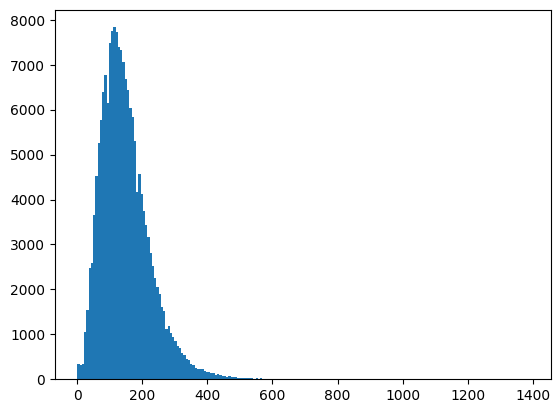

In [15]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=200);

In [16]:
output_char_len = np.percentile(char_lens, 95)
output_char_len

290.0

In [17]:
from keras import layers
max_tokens = 28
char_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=int(output_char_len),
    standardize="lower_and_strip_punctuation"
)
char_vectorizer.adapt(train_chars)

In [18]:
char_vectorizer(["H e l l o  L A !"])

2024-07-01 10:26:20.872345: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[13,  2, 12, 12,  7, 12,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

In [19]:
char_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=25
)

In [20]:
char_embedding(char_vectorizer([train_chars[0]]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[-0.0490144 , -0.03967799, -0.01455731, ..., -0.03500394,
          0.01277624,  0.00066807],
        [ 0.04199201, -0.02605927,  0.0358974 , ...,  0.04166627,
         -0.03173604,  0.00921617],
        [ 0.04863322, -0.02723846,  0.0398985 , ..., -0.00031919,
         -0.00546757,  0.0409555 ],
        ...,
        [ 0.03946539, -0.04021829, -0.01407636, ..., -0.01220665,
          0.02276686,  0.0080045 ],
        [ 0.03946539, -0.04021829, -0.01407636, ..., -0.01220665,
          0.02276686,  0.0080045 ],
        [ 0.03946539, -0.04021829, -0.01407636, ..., -0.01220665,
          0.02276686,  0.0080045 ]]], dtype=float32)>

In [21]:
import tensorflow_hub as tfhub
token_embedding = tfhub.KerasLayer(
    "../USE",
    trainable=False,
    input_shape=[],
    dtype=tf.string
)

## Label encoding

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.subject)
val_labels_encoded = label_encoder.transform(val_df.subject)
test_labels_encoded = label_encoder.transform(test_df.subject)
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Creating Datasets

In [23]:
# Prepearing datasets for fiiting
# Train
train_data = tf.data.Dataset.from_tensor_slices((
    train_df_line_number, 
    train_df_total_lines, 
    train_df.text, 
    train_chars))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Val
val_data = tf.data.Dataset.from_tensor_slices((val_df_line_number, val_df_total_lines, val_df.text, val_chars))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_dataset = tf.data.Dataset.zip((val_data, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Test
test_data = tf.data.Dataset.from_tensor_slices((test_df_line_number, test_df_total_lines, test_df.text, test_chars))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_dataset = tf.data.Dataset.zip((test_data, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

## Create a baseline

In [41]:
from tensorflow.keras import layers
#
line_number_input = layers.Input(int(avg_95_len_line_number),)
line_number_output = layers.Dense(32, activation="relu")(line_number_input)
line_number_model = tf.keras.Model(line_number_input, line_number_output)

#
total_lines_input = layers.Input(int(avg_95_len_total_lines),)
total_lines_output = layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input, total_lines_output)

# 
token_input = layers.Input([], dtype=tf.string)
token_embeds = token_embedding(token_input)
token_output = layers.Dense(128, activation="relu")(token_embeds)
token_model = tf.keras.Model(token_input, token_output)

#
char_input = layers.Input((1,), dtype=tf.string)
char_vectors = char_vectorizer(char_input)
char_embeds = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeds)
char_model = tf.keras.Model(char_input, char_bi_lstm)

#
char_token_embeddings = layers.Concatenate()([token_model.output, char_model.output])

z = layers.Dropout(0.5)(char_token_embeddings)
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.5)(z)

#
z = layers.Concatenate()([line_number_model.output, total_lines_model.output, z])

# 
output_layer = layers.Dense(5, activation="softmax")(z)

baseline_model = tf.keras.Model(
    [
        line_number_model.input,
        total_lines_model.input,
        token_model.input,
        char_model.input
    ],
    output_layer
)

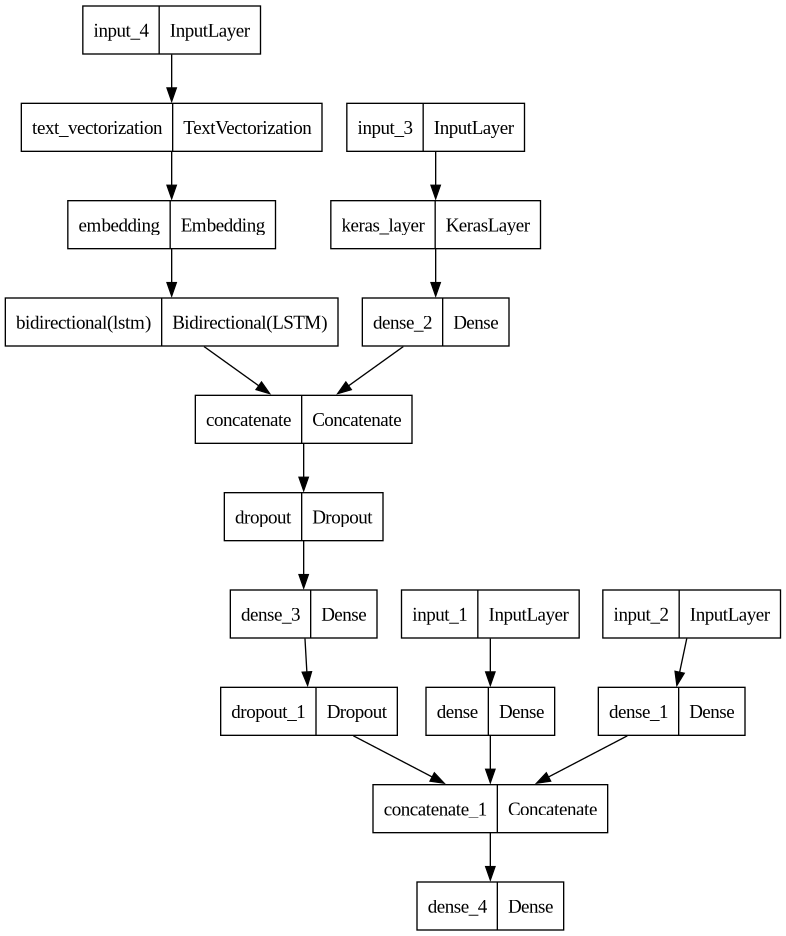

In [25]:
tf.keras.utils.plot_model(baseline_model)

In [26]:
baseline_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 290)                  0         ['input_4[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 keras_layer (KerasLayer)    (None, 512)                  2567978   ['input_3[0][0]']       

In [27]:
baseline_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [27]:
%time baseline_history = baseline_model.fit(train_dataset, epochs=5, validation_data = val_dataset, validation_steps=len(val_dataset))

Epoch 1/5


2024-06-29 22:41:33.912871: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-29 22:41:35.561457: I external/local_xla/xla/service/service.cc:168] XLA service 0x77406c055230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-29 22:41:35.561483: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-29 22:41:35.575105: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719690095.664476    2443 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5627/5627 [==============================] - 91s 15ms/step - loss: 0.9759 - accuracy: 0.8083 - val_loss: 0.9162 - val_accuracy: 0.8421
Epoch 2/5
5627/5627 [==============================] - 85s 15ms/step - loss: 0.9359 - accuracy: 0.8361 - val_loss: 0.9068 - val_accuracy: 0.8490
Epoch 3/5
5627/5627 [==============================] - 85s 15ms/step - loss: 0.9276 - accuracy: 0.8418 - val_loss: 0.9037 - val_accuracy: 0.8513
Epoch 4/5
5627/5627 [==============================] - 85s 15ms/step - loss: 0.9230 - accuracy: 0.8448 - val_loss: 0.9023 - val_accuracy: 0.8527
Epoch 5/5
5627/5627 [==============================] - 89s 16ms/step - loss: 0.9192 - accuracy: 0.8476 - val_loss: 0.9012 - val_accuracy: 0.8536
CPU times: user 13min 43s, sys: 46.1 s, total: 14min 29s
Wall time: 7min 13s


In [28]:
baseline_preds = tf.argmax(baseline_model.predict(test_dataset), axis=1)
baseline_preds

942/942 [==============================] - 7s 7ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [24]:
from helper_functions import calculate_results
# baseline_results = calculate_results(test_labels_encoded, baseline_preds)
# baseline_results['time'] = 433
baseline_results = {'accuracy': 84.73203915712627,
 'precision': 0.8481699363381078,
 'recall': 0.8473203915712626,
 'f1': 0.8437079537808914,
 'time': 433}
baseline_results

{'accuracy': 84.73203915712627,
 'precision': 0.8481699363381078,
 'recall': 0.8473203915712626,
 'f1': 0.8437079537808914,
 'time': 433}

## GloVe Embedding (try not to fit or anything else, hjust first of all - start glove embedding!!)

In [25]:
# !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [34]:
token_vectorizer = layers.TextVectorization(
  max_tokens=100_000, # How many words are in vocab
  output_sequence_length=50, # how long does sequences will be
  pad_to_max_tokens=True
)

In [35]:
token_vectorizer.adapt(train_df.text)
vocab = token_vectorizer.get_vocabulary()
vocab[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [40]:
# Prepare Glove File
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  # map from a token (word) to a Glove embedding vector
        wordToIndex = {}  # map from a token to an index
        indexToWord = {}  # map from an index to a token 

        for line in f:
            record = line.strip().split()
            token = record[0] # take the token (word) from the text line
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) # associate the Glove embedding vector to a that token (word)

        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  # 0 is reserved for masking in Keras (see above)
            wordToIndex[tok] = kerasIdx # associate an index to a token (word)
            indexToWord[kerasIdx] = tok # associate a word to a token (word). Note: inverse of dictionary above

    return wordToIndex, indexToWord, wordToGlove

# Create Pretrained Keras Embedding Layer
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  # adding 1 to account for masking
    embDim = next(iter(wordToGlove.values())).shape[0]  # works with any glove dimensions (e.g. 50)

    embeddingMatrix = np.zeros((vocabLen, embDim))  # initialize with zeros
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] # create embedding: word index to Glove word embedding

    embeddingLayer = tf.keras.layers.Embedding(vocabLen, embDim, weights=[embeddingMatrix], trainable=isTrainable)
    return embeddingLayer

In [ ]:
wordToIndex, indexToWord, wordToGlove = readGloveFile("GloVe/glove.6B.300d.txt")
pretrainedEmbeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, False)

### Building a model

In [29]:
char_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=25
)

In [30]:
line_number_input = layers.Input((int(avg_95_len_line_number),))
line_number_output = layers.Dense(32, activation='relu')(line_number_input)
line_number_model = tf.keras.Model(line_number_input, line_number_output)

total_lines_input = layers.Input((int(avg_95_len_total_lines),))
total_lines_output = layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input, total_lines_output)

token_input = layers.Input([], dtype=tf.string)
token_vectors = token_vectorizer(token_input)
token_embeds = pretrainedEmbeddingLayer(token_vectors)
x = layers.Dense(128, activation="relu")(token_embeds)
token_output = layers.GlobalMaxPooling1D()(x)
token_model = tf.keras.Model(token_input, token_output)

char_input = layers.Input((1,), dtype=tf.string)
char_vectors = char_vectorizer(char_input)
char_embeds = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeds)
char_model = tf.keras.Model(char_input, char_bi_lstm)

char_token_combined = layers.Concatenate()([token_model.output, char_model.output])

z = layers.Dropout(0.5)(char_token_combined)
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate()([line_number_model.output, total_lines_model.output, z])


output_layer = layers.Dense(5, activation="softmax")(z)

glove_model = tf.keras.Model(
    [
        line_number_model.input,
        total_lines_model.input,
        token_model.input,
        char_model.input
    ],
    output_layer
)

In [31]:
token_model.output, char_model.output

(<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'global_max_pooling1d')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'bidirectional')>)

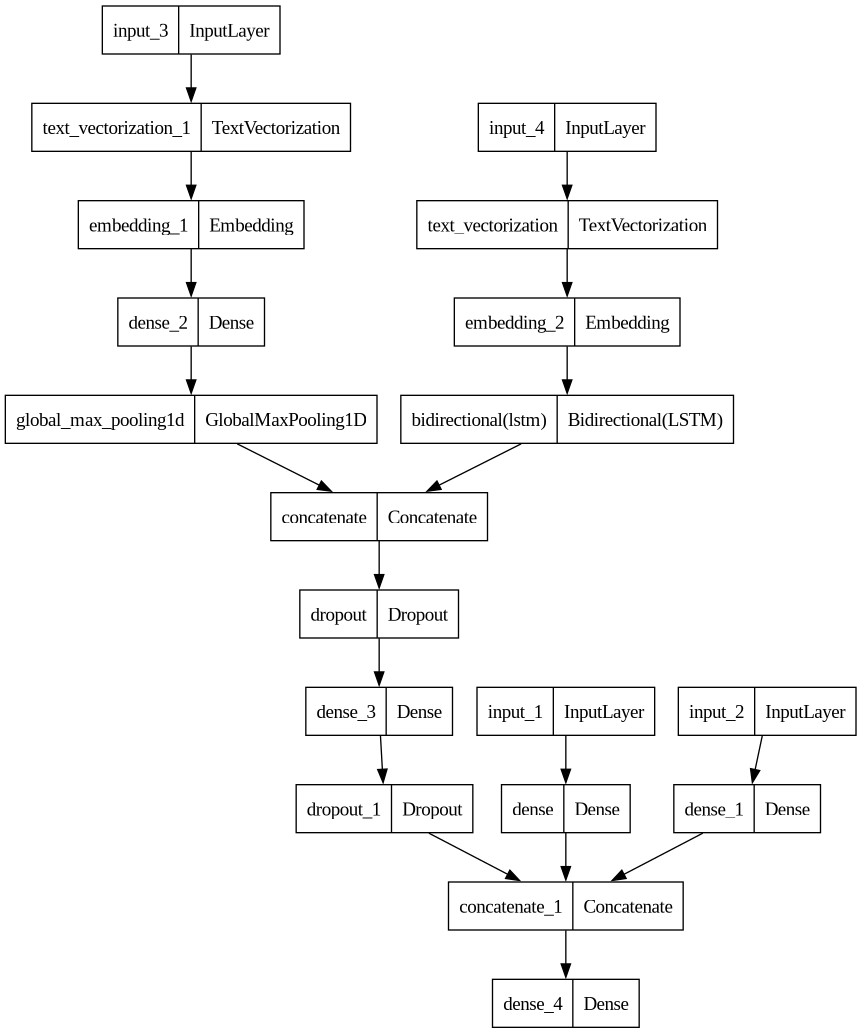

In [32]:
tf.keras.utils.plot_model(glove_model)

In [33]:
glove_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 50)                   0         ['input_3[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 300)              1200003   ['text_vectorization_1[0

In [36]:
glove_model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=["accuracy"]
)

In [ ]:
%time glove_history = glove_model.fit(train_dataset, epochs=5, validation_data = val_dataset, validation_steps=len(val_dataset))

Epoch 1/5


2024-07-01 00:10:55.379276: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-01 00:10:56.046755: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe96017d8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 00:10:56.046785: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-07-01 00:10:56.059391: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719781856.165244    2155 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5627/5627 [==============================] - 199s 35ms/step - loss: 1.0291 - accuracy: 0.7706 - val_loss: 0.9369 - val_accuracy: 0.8447
Epoch 2/5
5627/5627 [==============================] - 198s 35ms/step - loss: 0.9616 - accuracy: 0.8240 - val_loss: 0.9205 - val_accuracy: 0.8559
Epoch 3/5
4528/5627 [=======================>......] - ETA: 37s - loss: 0.9534 - accuracy: 0.8295

In [56]:
glove_preds = tf.argmax(glove_model.predict(test_dataset), axis=1)
glove_preds

942/942 [==============================] - 12s 12ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [25]:
# glove_results = calculate_results(test_labels_encoded, glove_preds)
# glove_results["time"] = 15*60 + 38
glove_results ={'accuracy': 85.1866600298656,
 'precision': 0.8517346677444203,
 'recall': 0.851866600298656,
 'f1': 0.8475873970647593,
 'time': 938}
glove_results

{'accuracy': 85.1866600298656,
 'precision': 0.8517346677444203,
 'recall': 0.851866600298656,
 'f1': 0.8475873970647593,
 'time': 938}

## Change to SGD

In [26]:
from tensorflow.keras import layers
#
line_number_input = layers.Input(int(avg_95_len_line_number),)
line_number_output = layers.Dense(32, activation="relu")(line_number_input)
line_number_model = tf.keras.Model(line_number_input, line_number_output)

#
total_lines_input = layers.Input(int(avg_95_len_total_lines),)
total_lines_output = layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input, total_lines_output)

# 
token_input = layers.Input([], dtype=tf.string)
token_embeds = token_embedding(token_input)
token_output = layers.Dense(128, activation="relu")(token_embeds)
token_model = tf.keras.Model(token_input, token_output)

#
char_input = layers.Input((1,), dtype=tf.string)
char_vectors = char_vectorizer(char_input)
char_embeds = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeds)
char_model = tf.keras.Model(char_input, char_bi_lstm)

#
char_token_embeddings = layers.Concatenate()([token_model.output, char_model.output])

z = layers.Dropout(0.5)(char_token_embeddings)
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.5)(z)

#
z = layers.Concatenate()([line_number_model.output, total_lines_model.output, z])

# 
output_layer = layers.Dense(5, activation="softmax")(z)

sgd_model = tf.keras.Model(
    [
        line_number_model.input,
        total_lines_model.input,
        token_model.input,
        char_model.input
    ],
    output_layer
)

In [27]:
sgd_model

In [28]:
sgd_model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=["accuracy"]
)

In [29]:
%time sgd_history = sgd_model.fit(train_dataset, epochs=5, validation_data = val_dataset, validation_steps=len(val_dataset))

Epoch 1/5


2024-07-01 10:26:32.497977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-01 10:26:34.442788: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d94d8d6bea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 10:26:34.442814: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
I0000 00:00:1719818794.504832    2064 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5627/5627 [==============================] - 106s 18ms/step - loss: 1.2911 - accuracy: 0.5659 - val_loss: 1.0826 - val_accuracy: 0.7193
Epoch 2/5
5627/5627 [==============================] - 96s 17ms/step - loss: 1.0770 - accuracy: 0.7254 - val_loss: 1.0199 - val_accuracy: 0.7672
Epoch 3/5
5627/5627 [==============================] - 99s 18ms/step - loss: 1.0402 - accuracy: 0.7553 - val_loss: 0.9984 - val_accuracy: 0.7854
Epoch 4/5
5627/5627 [==============================] - 106s 19ms/step - loss: 1.0199 - accuracy: 0.7713 - val_loss: 0.9822 - val_accuracy: 0.7980
Epoch 5/5
5627/5627 [==============================] - 103s 18ms/step - loss: 1.0045 - accuracy: 0.7844 - val_loss: 0.9704 - val_accuracy: 0.8084
CPU times: user 15min 46s, sys: 53.5 s, total: 16min 39s
Wall time: 8min 30s


In [30]:
sgd_preds = tf.argmax(sgd_model.predict(test_dataset), axis=1)
sgd_preds

942/942 [==============================] - 11s 10ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [32]:
# sgd_results = calculate_results(test_labels_encoded, sgd_preds)
# sgd_results["time"] = 8*60 + 30
sgd_results = {'accuracy': 80.71345611415298,
 'precision': 0.8054486718562726,
 'recall': 0.8071345611415298,
 'f1': 0.8026619304947755,
 'time': 510}
sgd_results

{'accuracy': 80.71345611415298,
 'precision': 0.8054486718562726,
 'recall': 0.8071345611415298,
 'f1': 0.8026619304947755,
 'time': 510}

## 1:1 model

In [41]:
wordToIndex, indexToWord, wordToGlove = readGloveFile("GloVe/glove.6B.300d.txt")
pretrainedEmbeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, True)

In [76]:
line_number_input = layers.Input((int(avg_95_len_line_number),))
line_number_output = layers.Dense(32, activation='relu')(line_number_input)
line_number_model = tf.keras.Model(line_number_input, line_number_output)

total_lines_input = layers.Input((int(avg_95_len_total_lines),))
total_lines_output = layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input, total_lines_output)

token_input = layers.Input([], dtype=tf.string)
token_vectors = token_vectorizer(token_input)
token_embeds = pretrainedEmbeddingLayer(token_vectors)
token_output = layers.GlobalMaxPooling1D()(token_embeds)
token_model = tf.keras.Model(token_input, token_output)

char_input = layers.Input((1,), dtype=tf.string)
char_vectors = char_vectorizer(char_input)
char_embeds = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeds)
char_model = tf.keras.Model(char_input, char_bi_lstm)

char_token_combined = layers.Concatenate()([token_model.output, char_model.output])

y = layers.Reshape((1, 350))(char_token_combined)
z = layers.Bidirectional(layers.LSTM(100))(y)

z = layers.Dropout(0.5)(z)
z = layers.Concatenate()([line_number_model.output, total_lines_model.output, z])
z = layers.Dropout(0.5)(z)

output_layer = layers.Dense(5, activation="softmax")(z)

paper_model = tf.keras.Model(
    [
        line_number_model.input,
        total_lines_model.input,
        token_model.input,
        char_model.input
    ],
    output_layer
)

In [78]:
paper_model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=["accuracy"]
)

### Load callbacks

In [ ]:
from helper_functions import create_tensorboard_callback

early_stopping = tf.ke

In [ ]:
%time sgd_history = sgd_model.fit(train_dataset, epochs=5, validation_data = val_dataset, validation_steps=len(val_dataset))